# Week 5B<br>Getting Data Part 1: Working with APIs
Oct 5, 2022

**Week #5 Agenda**

**Last time**:

- Introduction to APIs
- Pulling census data and shape files using Python

**Today:**

- Using the Twitter API
    - Plotting geocoded tweets
    - Word frequencies
    - Sentiment analysis

In [135]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

from matplotlib import pyplot as plt
import seaborn as sns

import time 
import hvplot.pandas
import holoviews as hv

In [2]:
import esri2gpd
import carto2gpd
import cenpy

In [3]:
pd.options.display.max_columns = 999

## API Example #2: the Twitter API

Twitter provides a rich source of information, but the challenge is how to extract the information from **semi-structured** data.

### Semi-structured data

Data that contains some elements that cannot be easily consumed by computers 

**Examples:** human-readable text, audio, images, etc

### Key challenges

- **Text mining**: analyzing blocks of text to extract the relevant pieces of information
- **Natural language processing (NLP)**: programming computers to process and analyze human languages
- **Sentiment analysis**: analyzing blocks of text to derive the attitude or emotional state of the person

## Getting a developer account

Twitter recently updated to v2 of its API, introducing new features and access levels. We'll need to apply for "developer" access by creating a new app to interface with the API

### Step 1: Make a Twitter account

### Step 2: Apply for Developer access

Sign up at: https://developer.twitter.com/en/portal/petition/essential/basic-info

You will need to apply for a Developer Account, answer a few questions, and then confirm your email address.

### Step 3: Create a new project and app

https://developer.twitter.com/en/portal/projects/new

You will need to describe your project use case. I used something like this:


> I'm using Twitter's API to perform a sentiment analysis as part of a class teaching Python. I will be interacting with the API using the Python package tweepy.

### Step 4: Edit your "User Authentication Settings"

- If you'd like to be able to post tweets through the API, specify the **read and write** permissions
- For the questions regarding app websites, I used "https://twitter.com/home"

### Step 5: Create your API keys

In the "Keys and Tokens" section of your app, generate new access tokens and **save them** somewhere. You will need the following:

- API token and secret token
- Access token and secret token
- Bearer token

## Twitter v2 Access Levels

The standard, free API ("Essential") allows you to search tweets from the past seven days, while academic research access allows you to search the full archive of tweets. 

<div>
    <img src="imgs/twitter-access-levels-v2.png" width=700 />
</div>

[More info about v2 access levels](https://developer.twitter.com/en/docs/twitter-api/getting-started/about-twitter-api#v2-access-level)

## A note about academic access

As listed on the Twitter docs, you should qualify under the following use case: "Affiliated with an academic institution AND have a clearly defined project".

However, last year, we had mixed success getting students approved for academic access to the Twitter API, with seemingly arbitrary denials from Twitter for some students. 

A couple of issues we ran into:

1. Twitter requires a well-defined research project description to apply. 
1. You also need a link to a public student directory website or a Google Scholar page, so that Twitter can verify your identity. 

**My recommendation** is that if you'd like to use the Twitter API for the final project, then you should wait to apply for academic access until your project proposal is finished. 

You can apply for academic access using [this page](https://developer.twitter.com/en/portal/petition/academic/is-it-right-for-you). More information about the application process is available at [this link](https://developer.twitter.com/en/products/twitter-api/academic-research/application-info).


## Tweepy: a Python interface to Twitter

https://tweepy.readthedocs.io

In [5]:
import tweepy as tw

### Define your API keys

In [49]:
# INPUT YOUR API TOKENS HERE
BEARER_TOKEN = ""
API_KEY = ""
API_KEY_SECRET = ""
ACCESS_TOKEN = ""
ACCESS_TOKEN_SECRET = ""

### Initialize an API object

We need to:

- step up authentication
- intialize a `tweepy.API` object

In [50]:
# Initialize the API client and tell tweepy to wait if rate limit is met
client = tw.Client(
    bearer_token=BEARER_TOKEN,
    consumer_key=API_KEY,
    consumer_secret=API_KEY_SECRET,
    access_token=ACCESS_TOKEN,
    access_token_secret=ACCESS_TOKEN_SECRET,
    wait_on_rate_limit=True,
)

### Rate Limits

**Be careful**: With the free API, you are allowed 180 API requests every 15 minutes.

See the [v2 Rate Limits](https://developer.twitter.com/en/docs/twitter-api/rate-limits) documentation for more details.

### What does `wait_on_rate_limit` do?

If you run into a rate limit while pulling tweets, this will tell `tweepy` to wait 15 minutes until it can continue. 

Unfortunately, you need to sign up (and pay) for the premium API to avoid these rate limits.

### Several different APIs available

Including user tweets, mentions, searching keywords, favoriting, direct messages, and more...

See the [Tweepy API documentation](https://docs.tweepy.org/en/stable/client.html) for tweepy.Client.

### You can also stream tweets

You can set up a **listener** to listen for new tweets and download them in real time (subject to rate limits).

We won't focus on this, but there is a nice [tutorial](https://docs.tweepy.org/en/stable/streaming.html) on the Tweepy documentation.

### You can also tweet (if you want!)

You can post tweets using the `update_status()` function. For example:

```python
tweet = 'Hello World!'
client.create_tweet(text=tweet)
```

In [52]:
#tweet = 'Hello World!'
#client.create_tweet(text=tweet)

## The Twitter Search API



There are two search API endpoints:

1. `client.search_recent_tweets()` [docs](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_recent_tweets): Search one recent tweets within the last 7 days, 
1. `client.search_all_tweets()` [docs](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_all_tweets): Search all historical tweets going back to 2006. 

For this lecture, we'll use the `client.search_recent_tweets()` function since we are limited to the free API. If you have the academic access level, you can use the `client.search_all_tweets()` endpoint instead. In that case, you can re-run this whole lecture and just substitute the function and everything will still work!

### 1. Getting tweets from the past 7 days

You will have to pass it a search query using the `query` keyword to specify the data that you are looking for. In the example below, we are searching for tweets with the "#phillies" hashtag.

By default, only the text and tweet id are returned by Tweepy. You can request more fields using the `tweet_fields` keyword. Available attributes are listed [on the documentation for the v2 data dictionary](https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet). Below, we add the "created_at" and "public_metrics" fields in the example below.

By default, a request returns 10 tweets. If you want more than 10 tweets per request, you can specify that using the `max_results` parameter. The maximum Tweets per request is 100.

In [92]:
client.search_recent_tweets?

Signature: client.search_recent_tweets(query, *, user_auth=False, **params)
Docstring:
search_recent_tweets(             query, *, end_time=None, expansions=None, max_results=None,             media_fields=None, next_token=None, place_fields=None,             poll_fields=None, since_id=None, sort_order=None,             start_time=None, tweet_fields=None, until_id=None,             user_fields=None, user_auth=False         )

The recent search endpoint returns Tweets from the last seven days that
match a search query.

The Tweets returned by this endpoint count towards the Project-level
`Tweet cap`_.

.. versionchanged:: 4.6
    Added ``sort_order`` parameter

Parameters
----------
query : str
    One rule for matching Tweets. If you are using a
    `Standard Project`_ at the Basic `access level`_, you can use the
    basic set of `operators`_ and can make queries up to 512 characters
    long. If you are using an `Academic Research Project`_ at the Basic
    access level, you can use 

In [63]:
# Collect tweets related to the phillies
search_words = "#phillies"

# Get tweets from the past 7 days
tweets = client.search_recent_tweets(
    query=search_words, tweet_fields=["created_at", "public_metrics"], max_results=100
)

The "data" attribute contains the tweet information.

In [64]:
len(tweets.data)

100

Let's get the first tweet.

In [73]:
first_tweet = tweets.data[0]

In [74]:
first_tweet

<Tweet id=1577736998764396549 text='RT @ScottLauber: #Phillies-Cardinals start times, all times Eastern:\nGame 1: Friday, 2:07 p.m.\nGame 2: Saturday, 8:37 p.m.\nGame 3, if neces…'>

Lots of data is available, **but you have to specify it in the "tweet_fields" keyword!**

In [ ]:
# Tab complete to see available attributes
# first_tweet.

In [127]:
dict(first_tweet)

{'id': 1577736998764396549,
 'text': 'RT @ScottLauber: #Phillies-Cardinals start times, all times Eastern:\nGame 1: Friday, 2:07 p.m.\nGame 2: Saturday, 8:37 p.m.\nGame 3, if neces…',
 'edit_history_tweet_ids': ['1577736998764396549'],
 'public_metrics': {'retweet_count': 8,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0},
 'created_at': datetime.datetime(2022, 10, 5, 19, 6, 28, tzinfo=datetime.timezone.utc)}

The text:

In [84]:
first_tweet.text

'RT @ScottLauber: #Phillies-Cardinals start times, all times Eastern:\nGame 1: Friday, 2:07 p.m.\nGame 2: Saturday, 8:37 p.m.\nGame 3, if neces…'

The tweet time:

In [87]:
first_tweet.created_at

datetime.datetime(2022, 10, 5, 19, 6, 28, tzinfo=datetime.timezone.utc)

Public metrics:

In [76]:
first_tweet.public_metrics

{'retweet_count': 8, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}

### 2. Getting geographic data

We need to tell tweepy to give us more info about each geographic "place" using the `place_fields` and `expansions` keywords.

In [102]:
client = tw.Client(
    bearer_token=BEARER_TOKEN,
    consumer_key=API_KEY,
    consumer_secret=API_KEY_SECRET,
    access_token=ACCESS_TOKEN,
    access_token_secret=ACCESS_TOKEN_SECRET,
    wait_on_rate_limit=True,
)

In [103]:
tweets = client.search_recent_tweets(
    query=search_words,
    tweet_fields=["created_at", "geo"],
    place_fields=["place_type", "geo"],
    expansions="geo.place_id",
    max_results=100,
)

In addition to the "data" attribute, we have a list of all of the 'places' associated with the tweets:


In [117]:
tweets.includes['places']

[<Place id=01a9a39529b27f36 full_name=Manhattan, NY>]

Create a dictionary where keys are the place IDs and values are the place objects:

In [118]:
places = {p["id"]: p for p in tweets.includes['places']}

Let's see if any tweets have geo info that isn't `None`

In [128]:
tweets_with_geo = [tweet for tweet in tweets.data if tweet.geo is not None]

In [129]:
len(tweets_with_geo)

1

**Note:** only a small fraction of tweets have geo information, meaning that you will need a *large* volume of tweets to do a geospatial analysis.

In [130]:
t = tweets_with_geo[0]

In [131]:
t

<Tweet id=1577736973665636353 text='@MLB #OMG 🤣🥳😎🤓🎃❣️❣️❣️#phillies https://t.co/JwMEURMlWT'>

In [132]:
t.geo

{'place_id': '01a9a39529b27f36'}

In [123]:
place = places[t.geo['place_id']]

place

<Place id=01a9a39529b27f36 full_name=Manhattan, NY>

In [133]:
dict(place)

{'full_name': 'Manhattan, NY',
 'geo': {'type': 'Feature',
  'bbox': [-74.026675, 40.683935, -73.910408, 40.877483],
  'properties': {}},
 'id': '01a9a39529b27f36',
 'place_type': 'city'}

Geographic features will vary! Some will be places with bounding boxes, some with latitude/longitude, but most with no geographic info at all.

### 3. Getting more than 100 tweets

We will use the `Paginator()` object to iterate over "pages" of tweets.

You can also optionally specify the `end_time` keyword if you want to limit the timeframe to return tweets from. By default, this is about 30 seconds in the past (the most recent available). **Note** that with the free API you can only get tweets going back 7 days.

In [137]:
client = tw.Client(
    bearer_token=BEARER_TOKEN,
    consumer_key=API_KEY,
    consumer_secret=API_KEY_SECRET,
    access_token=ACCESS_TOKEN,
    access_token_secret=ACCESS_TOKEN_SECRET,
    wait_on_rate_limit=True,
)

In [147]:
# Store tweets from all pages
all_tweets = []

# Track how many requests
requests_made = 0

# Use the paginator to loop over all available tweets in batches of 100
# This pulls 100 tweets per page for 5 pages to get 500 total
for tweets in tw.Paginator(
    client.search_recent_tweets,    # The API endpoint
    query="#phillies",              # The search query
    tweet_fields=["created_at"],    # Additional fields
    max_results=100,  # How many tweets per page
    limit=5,  # NEW: How many pages to retrieve
):

    # Saves all of the tweets
    all_tweets += tweets.data

    # Sleep for 1 second to avoid rate limit
    time.sleep(1)

    # Log each time a new request is made
    requests_made = requests_made + 1
    print(f"After request #{requests_made}, total # tweets = {len(all_tweets)}")

After request #1, total # tweets = 100
After request #2, total # tweets = 200
After request #3, total # tweets = 300
After request #4, total # tweets = 400
After request #5, total # tweets = 500


In [148]:
len(all_tweets)

500

### 4. Customizing our search query

The [the documentation](https://developer.twitter.com/en/docs/twitter-api/enterprise/rules-and-filtering/operators-by-product) has examples of different query string use cases for filtering the results. The examples that can use with the search API have a dark blue "SEARCH" tag. 

You can also filter tweets by location, as in this [tutorial](https://developer.twitter.com/en/docs/tutorials/filtering-tweets-by-location) on the Twitter documentation. Specifically, this tutorial includes [a number of examples](https://developer.twitter.com/en/docs/tutorials/filtering-tweets-by-location#usage-examples).

#### Let's remove retweets

We will use the "is" operator to select only retweets and then use a "-" to negate this operator.

In [157]:
search_words = "#phillies"
new_search = search_words + " -is:retweet"

Get a new tweets using our new search query:

In [158]:
client = tw.Client(
    bearer_token=BEARER_TOKEN,
    consumer_key=API_KEY,
    consumer_secret=API_KEY_SECRET,
    access_token=ACCESS_TOKEN,
    access_token_secret=ACCESS_TOKEN_SECRET,
    wait_on_rate_limit=True,
)

In [159]:
tweets = client.search_recent_tweets(
    query=new_search, tweet_fields=["created_at", "public_metrics"], max_results=100
)

#### Did it work?

In [162]:
for tweet in tweets.data[:10]:
    print(tweet.text)

@Phillies retired in Top 3rd.. Valdez collects 2 more strike outs
Kyle Schwarber should've walked, "strike one" was not a strike
Rhys Hoskins 6-3 ground out, the umpire lost track of the count, pitch #4 was a swing and a miss at strike three?
#Phillies #RingTheBell
Here's a quick look at betting odds for the Wild Card round:

#Padres-#Mets: https://t.co/cpUvAdfNc6

#Phillies-#STLCards: https://t.co/t8O3cmEB2H

#BlueJays-#Mariners: https://t.co/nyXwsCuEfZ

#Rays-#Guardians: https://t.co/Etmp66on00
With his K in the 3rd, Kyle Schwarber becomes the first Phillie to strike out 200 times in a season.

He surpasses Ryan Howard's #Phillies record of 199 in 2007 and '08.

It's the 16th 200+ K season in the majors.
https://t.co/sHFigLvUeD https://t.co/Drbq1aSrR6
@kneerecon #Pitt #PennState #Phillies #Sixers #Eagles #SteelersNation #Steelers #Penguins #PiratesStrong #IndependenceHall #LibertyBell #Flyers #Pennsylvania #Penn #Temple #Drexel #LehighUniversity #ShippensburgUniversity #Bucknell #IUP

## Use case #1: calculating word frequencies

An example of **text mining**

### Load the most recent 1,000 tweets

Save the text of 1,000 tweets after querying our cursor object.

In [ ]:
client = tw.Client(
    bearer_token=BEARER_TOKEN,
    consumer_key=API_KEY,
    consumer_secret=API_KEY_SECRET,
    access_token=ACCESS_TOKEN,
    access_token_secret=ACCESS_TOKEN_SECRET,
    wait_on_rate_limit=True,
)

In [163]:
# Store all tweet data
tweet_data = []

for tweets in tw.Paginator(
    client.search_recent_tweets,
    query="#phillies -is:retweet",
    tweet_fields=["created_at"],
    max_results=100,
    limit=10, # 10 pages, each with 100 tweets
):

    # Saves all of the tweets
    tweet_data += tweets.data

    # Sleep for 1 second to avoid rate limit
    time.sleep(1)

In [164]:
len(tweet_data)

1000

In [165]:
# Get the text of the tweets
tweets_text = [tweet.text for tweet in tweet_data]

In [166]:
# the first five tweets
tweets_text[:5]

['Hey look, more Pooh this afternoon. \n#phillies #mlb https://t.co/jlW09pHi8U',
 'Dan Bellino: 6.98% BCR - 4 Stars\n#Astros 10 vs. #Phillies 0\n#LevelUp vs. #RingTheBell https://t.co/znG6I8HxH8',
 'Can\'t say I\'m suprised #Phillies have the longest odds in NL to win pennant. Good pitching beats an "all or nothing" line up. (Bad teams they beat up on, couldn\'t pitch), all the NL Playoff teams can.',
 '@Phillies retired in Top 3rd.. Valdez collects 2 more strike outs\nKyle Schwarber should\'ve walked, "strike one" was not a strike\nRhys Hoskins 6-3 ground out, the umpire lost track of the count, pitch #4 was a swing and a miss at strike three?\n#Phillies #RingTheBell',
 "Here's a quick look at betting odds for the Wild Card round:\n\n#Padres-#Mets: https://t.co/cpUvAdfNc6\n\n#Phillies-#STLCards: https://t.co/t8O3cmEB2H\n\n#BlueJays-#Mariners: https://t.co/nyXwsCuEfZ\n\n#Rays-#Guardians: https://t.co/Etmp66on00"]

### Text mining and dealing with messy data

1. Remove URLs $\rightarrow$ regular expressions
1. Remove **stop words**
1. Remove the search terms

#### Step 1: Removing URLs

**Regular expressions**

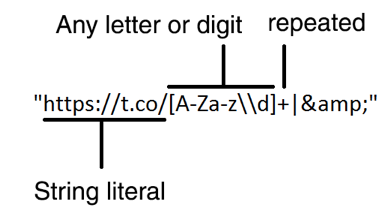

This will identify "t.co" in URLs.

**Good Tutorial on Regular Expressions**: See [this post](https://piazza.com/class/l7ewjjtnsdw53o/post/44) on Piazza.

https://regexone.com/

Don't worry about mastering regular expression syntax...

StackOverflow is your friend

In [167]:
def remove_url(txt):
    """
    Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    import re
    return " ".join(re.sub("https://t.co/[A-Za-z\\d]+|&amp", "", txt).split())

**Remove any URLs**

In [168]:
tweets_no_urls = [remove_url(tweet) for tweet in tweets_text]
tweets_no_urls[:5]

['Hey look, more Pooh this afternoon. #phillies #mlb',
 'Dan Bellino: 6.98% BCR - 4 Stars #Astros 10 vs. #Phillies 0 #LevelUp vs. #RingTheBell',
 'Can\'t say I\'m suprised #Phillies have the longest odds in NL to win pennant. Good pitching beats an "all or nothing" line up. (Bad teams they beat up on, couldn\'t pitch), all the NL Playoff teams can.',
 '@Phillies retired in Top 3rd.. Valdez collects 2 more strike outs Kyle Schwarber should\'ve walked, "strike one" was not a strike Rhys Hoskins 6-3 ground out, the umpire lost track of the count, pitch #4 was a swing and a miss at strike three? #Phillies #RingTheBell',
 "Here's a quick look at betting odds for the Wild Card round: #Padres-#Mets: #Phillies-#STLCards: #BlueJays-#Mariners: #Rays-#Guardians:"]

**Extract a list of lower-cased words in a tweet**

- `.lower()` makes all words lower cased
- `.split()` splits a string into the individual words

In [173]:
example_string = "This is an Example"

example_string.lower()

'this is an example'

In [174]:
"This is an Example".lower().split()

['this', 'is', 'an', 'example']

Apply these functions to all tweets:

In [175]:
words_in_tweet = [tweet.lower().split() for tweet in tweets_no_urls]
words_in_tweet[1]

['dan',
 'bellino:',
 '6.98%',
 'bcr',
 '-',
 '4',
 'stars',
 '#astros',
 '10',
 'vs.',
 '#phillies',
 '0',
 '#levelup',
 'vs.',
 '#ringthebell']

**Count word frequencies**

We'll define a helper function to calculate word frequencies from our lists of words.

In [177]:
def count_word_frequencies(words_in_tweet, top=15):
    """
    Given a list of all words for every tweet, count
    word frequencies across all tweets.

    By default, this returns the top 15 words, but you
    can specify a different value for `top`.
    """
    import itertools, collections

    # List of all words across tweets
    all_words = list(itertools.chain(*words_in_tweet))

    # Create counter
    counter = collections.Counter(all_words)

    return pd.DataFrame(counter.most_common(top), columns=["words", "count"])

In [178]:
counts_no_urls = count_word_frequencies(words_in_tweet, top=15)
counts_no_urls.head(n=15)

,words,count
0,the,996
1,#phillies,952
2,a,342
3,to,341
4,in,292
5,and,248
6,of,231
7,#ringthebell,230
8,#astros,194
9,for,181


**Plot the frequencies**

Use `seaborn` to plot our DataFrame of word counts...

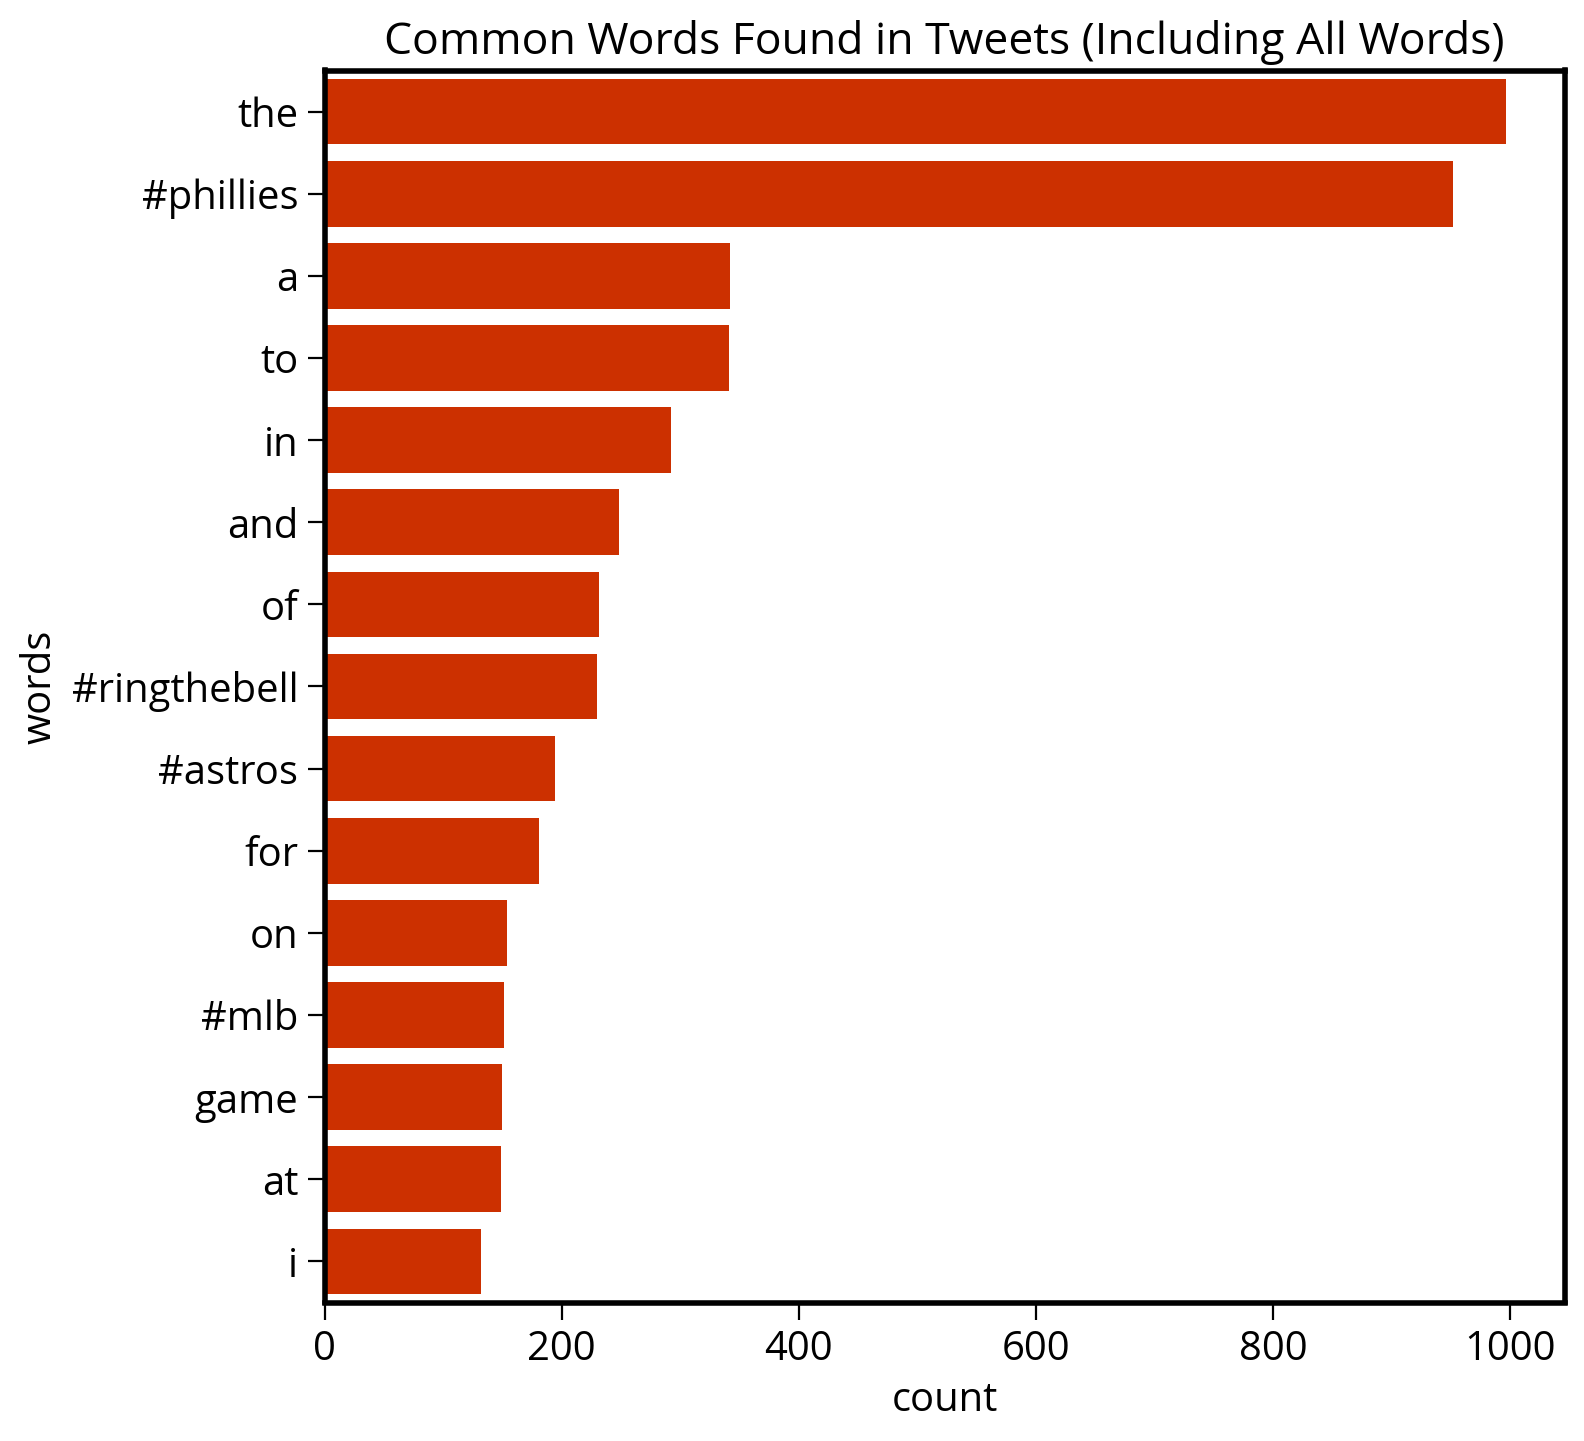

In [180]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
sns.barplot(
    y="words",
    x="count",
    data=counts_no_urls.sort_values(by="count", ascending=False),
    ax=ax,
    color="#cc3000",
    saturation=1.0,
)

ax.set_title("Common Words Found in Tweets (Including All Words)", fontsize=16);

#### Step 2: Remove stop words and punctuation

Common words that do not carry much significance and are often ignored in text analysis.

We can use the `nltk` package.

The "Natural Language Toolkit" https://www.nltk.org/

##### Import and download the stop words

In [181]:
import nltk
nltk.download('stopwords');

[nltk_data] Downloading package stopwords to /Users/nhand/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##### Get the list of common stop words

In [182]:
stop_words = list(set(nltk.corpus.stopwords.words('english')))

stop_words[:10]

["shouldn't", 'again', 'isn', 'up', 'ain', 'same', 'she', 'into', 'o', 'once']

In [183]:
len(stop_words)

179

##### Get the list of common punctuation

In [184]:
import string

In [185]:
punctuation = list(string.punctuation)

In [186]:
punctuation[:5]

['!', '"', '#', '$', '%']

##### Remove stop words from our tweets

In [ ]:
ignored = stop_words + punctuation

In [197]:
ignored[:10]

["shouldn't", 'again', 'isn', 'up', 'ain', 'same', 'she', 'into', 'o', 'once']

Get a list where each element is a list of valid words in the tweet:

In [194]:
def is_word_valid(word):
    return word not in ignored


tweets_nsw = [
    [word for word in tweet_words if is_word_valid(word)]
    for tweet_words in words_in_tweet
]


tweets_nsw[0]

['hey', 'look,', 'pooh', 'afternoon.', '#phillies', '#mlb']

This is just a double for loop using Pythons *inline syntax*. It's equivalent to:

```python
tweets_nsw = []
for tweet_words in words_in_tweet:
    
    temp = []
    for word in tweet_words:
        if is_word_valid(word):
            temp.append(word)

    tweets_nsw.append(temp)
```

##### Get our DataFrame of frequencies

In [198]:
counts_nsw = count_word_frequencies(tweets_nsw)
counts_nsw.head(n=15)

,words,count
0,#phillies,952
1,#ringthebell,230
2,#astros,194
3,#mlb,151
4,game,150
5,phillies,129
6,0,80
7,astros,70
8,@phillies,68
9,last,66


And plot...

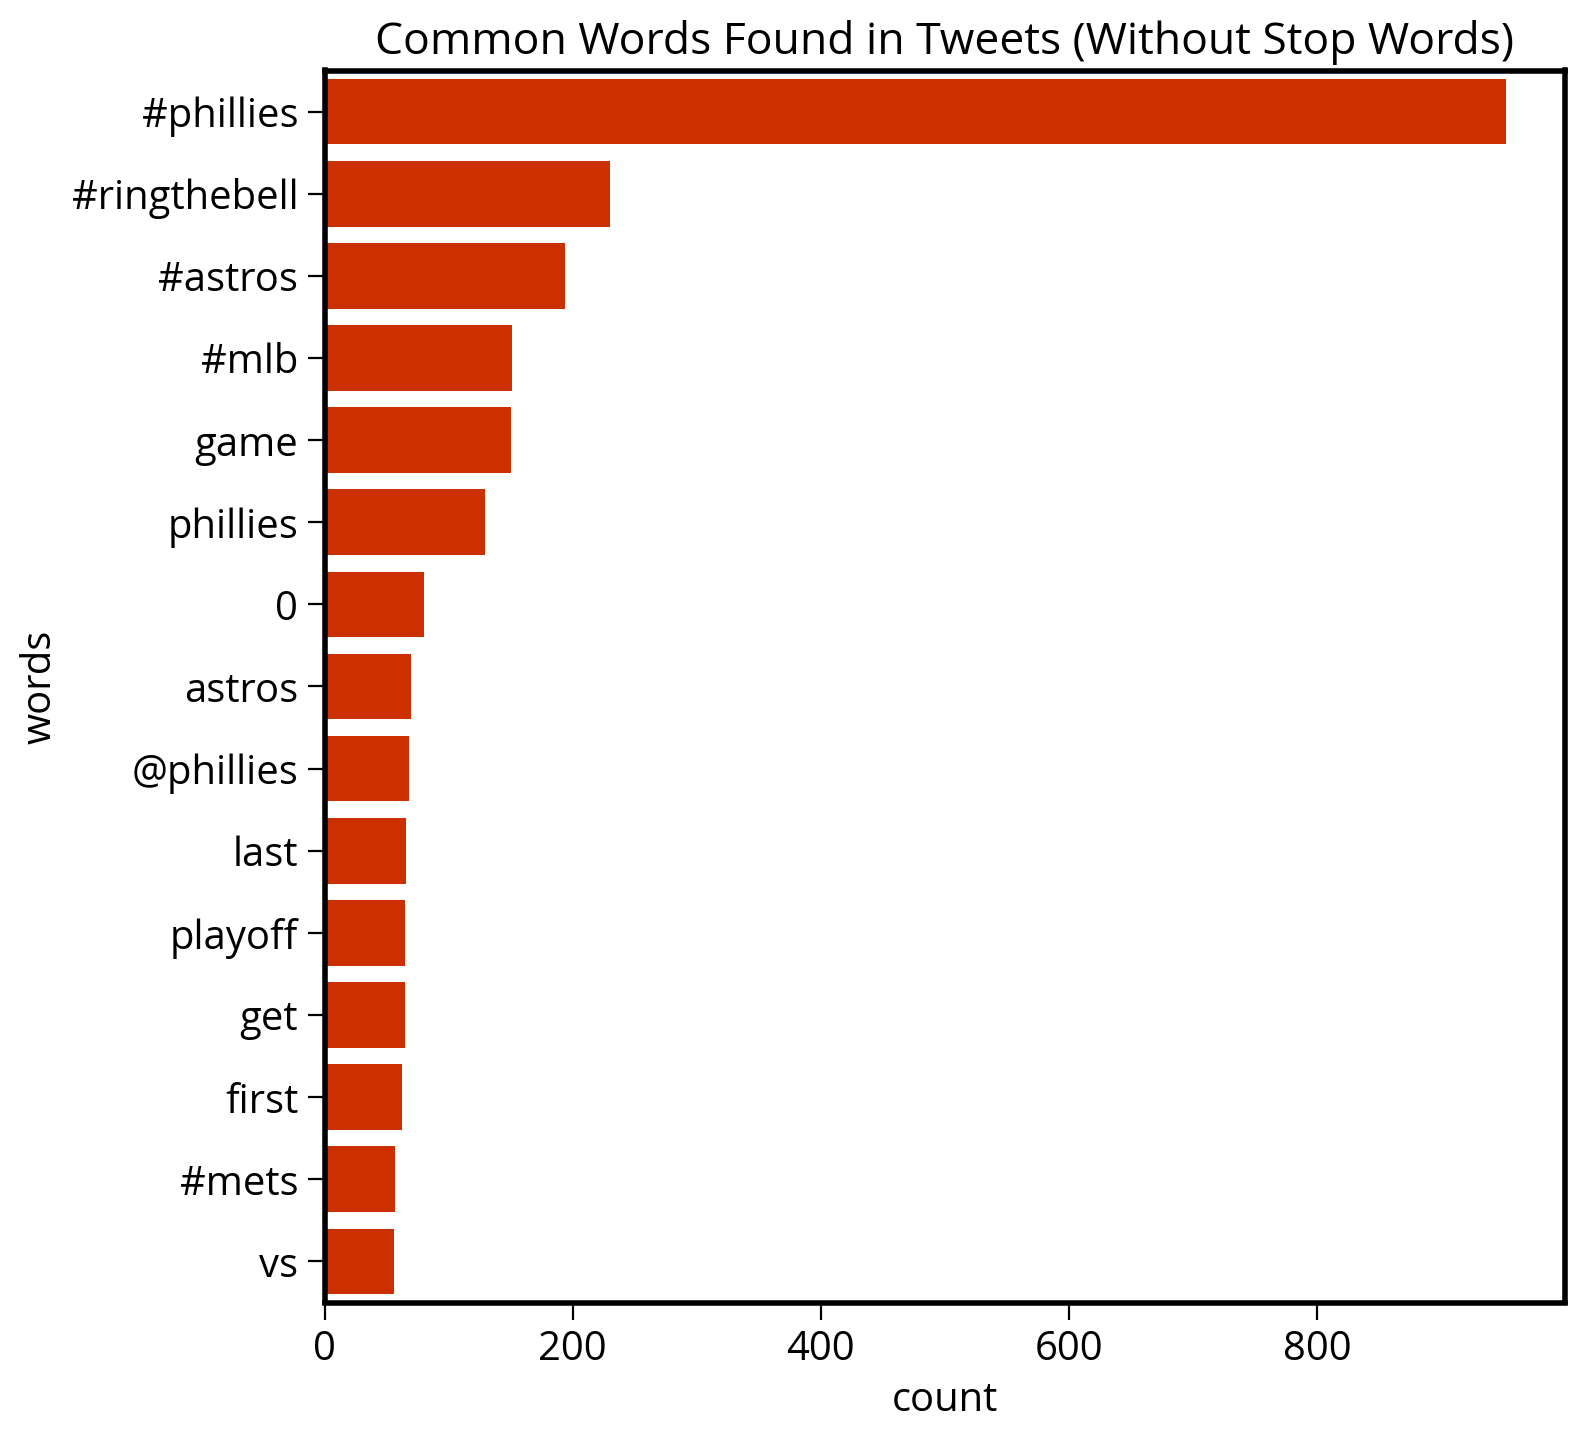

In [199]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(
    y="words",
    x="count",
    data=counts_nsw.sort_values(by="count", ascending=False),
    ax=ax,
    color="#cc3000",
    saturation=1.0,
)

ax.set_title("Common Words Found in Tweets (Without Stop Words)", fontsize=16);

#### Step 3: remove our query terms

Now, we'll be left with only the **meanigful** words...

In [201]:
search_terms = ["#phillies", "phillies", "@phillies", "#ringthebell"]
tweets_final = [[w for w in word if w not in search_terms] for word in tweets_nsw]

In [202]:
# frequency counts
counts_final = count_word_frequencies(tweets_final)

And now, plot the cleaned tweets...

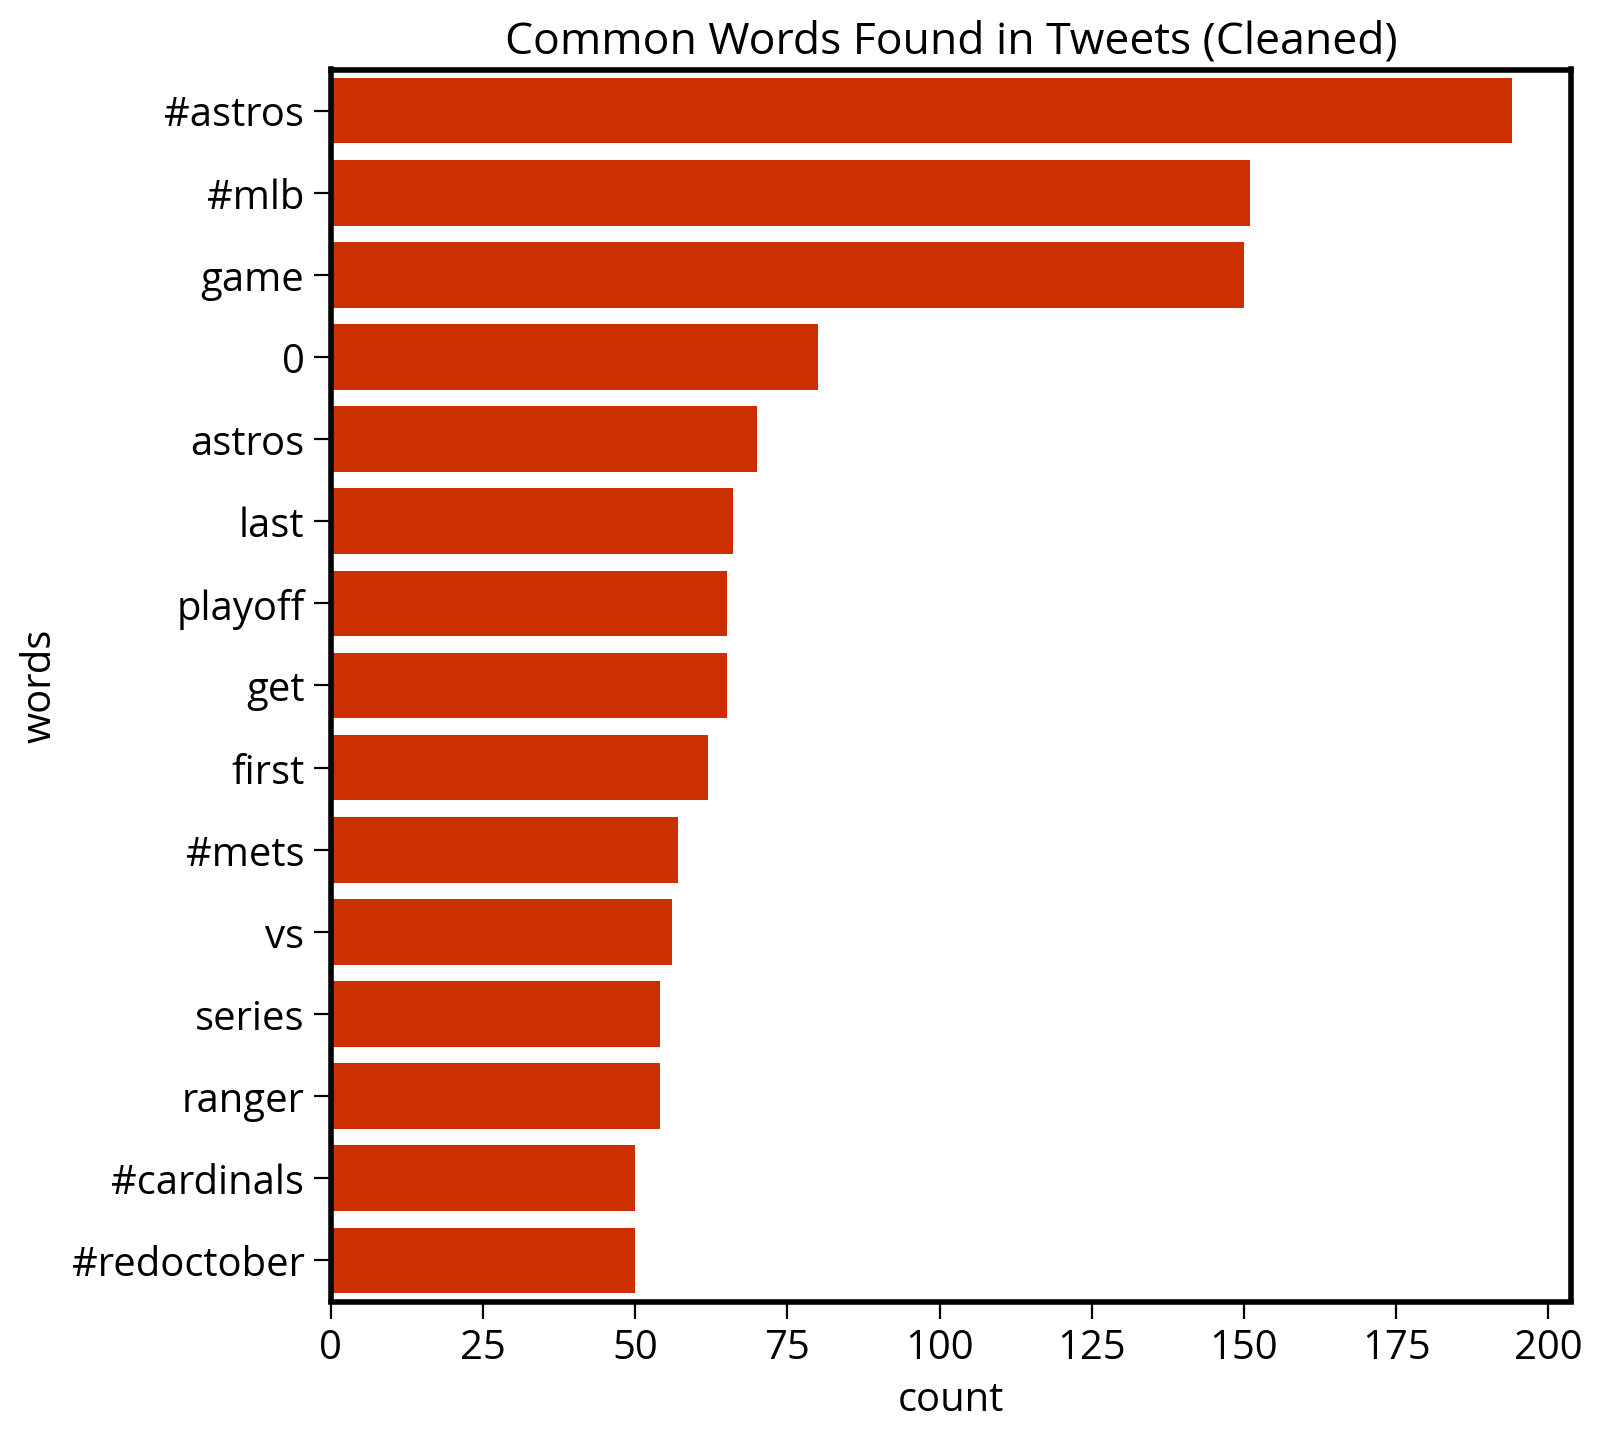

In [204]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(
    y="words",
    x="count",
    data=counts_final.sort_values(by="count", ascending=False),
    ax=ax,
    color="#cc3000",
    saturation=1.0,
)

ax.set_title("Common Words Found in Tweets (Cleaned)", fontsize=16);

#### Text mining: At home exercise

Get 1,000 tweets using a query string of your choice and plot the word frequencies.

Be sure to:
- remove URLs
- remove stop words / punctuation
- remove your search query terms

**Note**: if you try to pull more than 1,000 tweets you will likely run into the rate limit and have to wait 15 minutes.

**Remember:** The [documentation](https://developer.twitter.com/en/docs/twitter-api/enterprise/rules-and-filtering/operators-by-product) has examples of different query string use cases for filtering the results.

## Use case #2: sentiment analysis

The goal of a **sentiment analysis** is to determine the attitude or emotional state of the person who sent a particular tweet. 

Often used by brands to evaluate public opinion about a product. 

### The goal 

Determine the "sentiment" of every word in the English language

**The hard way**

Train a machine learning algorithm to classify words as positive vs. negative, given an input training sample of words.

**The easy way**

Luckily, this is a **very common** task in NLP and there are several packages available that have done the hard work for you. 

They provide out-of-the-box sentiment analysis using pre-trained machine learning algorithms.

**We'll be using `textblob`**

In [205]:
import textblob

### Let's analyze our set of 1,000 #phillies tweets

### Create our "text blobs"

Simply pass the tweet text to the `TextBlob()` object.

**Note:** it's best to remove any URLs first!

In [213]:
blobs = [textblob.TextBlob(remove_url(t.text)) for t in tweet_data]

In [214]:
blobs[0]

TextBlob("Hey look, more Pooh this afternoon. #phillies #mlb")

In [215]:
blobs[0].sentiment

Sentiment(polarity=0.5, subjectivity=0.5)

### Combine the data into a DataFrame

Track the polarity, subjectivity, and date of each tweet.

In [217]:
data = {}
data['date'] = [tweet.created_at for tweet in tweet_data]
data['polarity'] = [blob.sentiment.polarity for blob in blobs]
data['subjectivity'] = [blob.sentiment.subjectivity for blob in blobs]
data['text'] = [remove_url(tweet.text) for tweet in tweet_data]
data = pd.DataFrame(data)

In [218]:
data.head()

,date,polarity,subjectivity,text
0,2022-10-05 21:08:25+00:00,0.500000,0.500000,"Hey look, more Pooh this afternoon. #phillies ..."
1,2022-10-05 21:08:21+00:00,0.000000,0.000000,Dan Bellino: 6.98% BCR - 4 Stars #Astros 10 vs...
2,2022-10-05 21:06:08+00:00,0.266667,0.555556,Can't say I'm suprised #Phillies have the long...
3,2022-10-05 21:04:47+00:00,0.333333,0.333333,@Phillies retired in Top 3rd.. Valdez collects...
4,2022-10-05 21:03:22+00:00,0.077778,0.433333,Here's a quick look at betting odds for the Wi...


### How many are unbiased? 

We can remove tweets with a polarity of zero to get a better sense of emotions.

In [219]:
zero = (data['polarity']==0).sum()
print("number of unbiased tweets = ", zero)

number of unbiased tweets =  422


In [220]:
# remove unbiased tweets
biased = data.loc[ data['polarity'] != 0 ].copy()

### What does a polarized tweet look like?

We can find the tweet with the maximum positive/negative scores

##### The most negative

Use the `idxmin()` function:

In [221]:
biased['polarity'].idxmin()

155

In [222]:
biased.loc[biased['polarity'].idxmin(), 'text']

'It’s Cardinal Hate Week? I’m on board! #FlyEaglesFly #Phillies'

#### The most positive

Use the `idxmax()` function

In [223]:
biased.loc[biased['polarity'].idxmax(), 'text']

'The best day of baseball IMHO. Day 1 of Wildcard. I got #Phillies, #Mariners, #Guardians and #Padres. One can dream. #MLB'

### Plot a histogram of polarity

**Important:** Polarity runs from -1 (most negative) to +1 (most positive)

We can use matplotlib's `hist()` function:

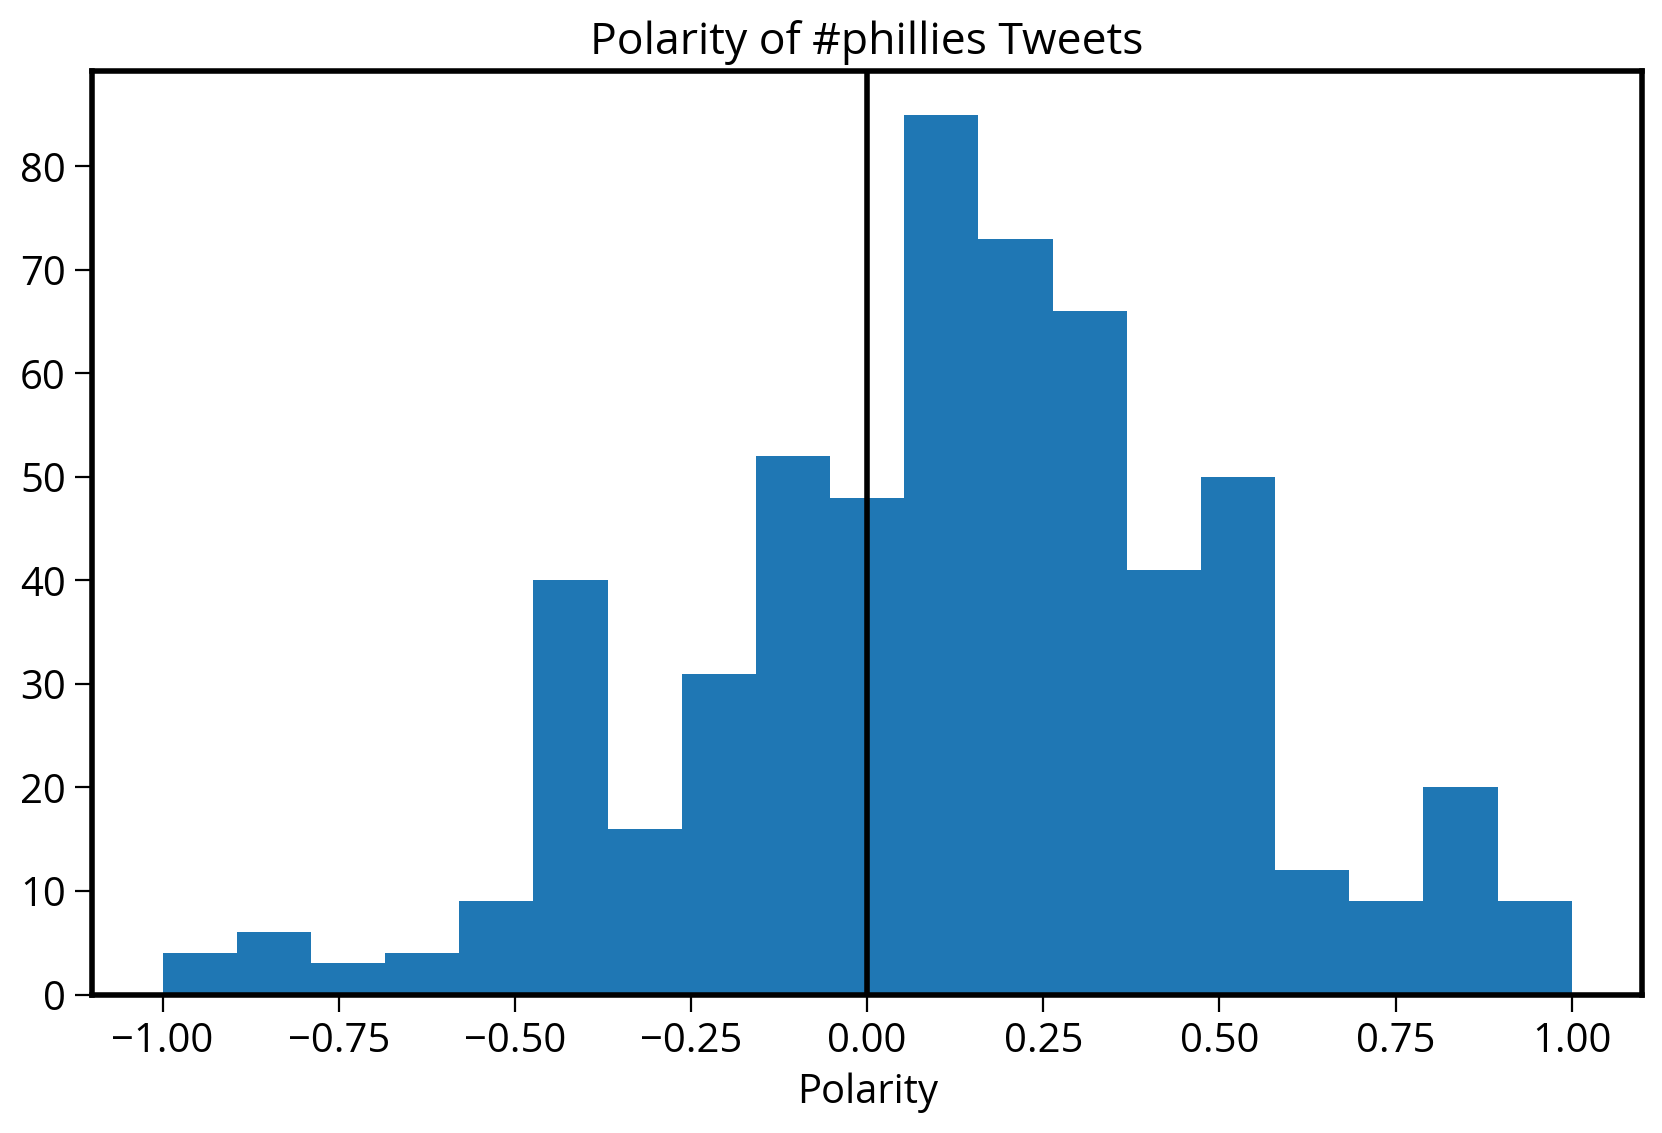

In [225]:
# create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# histogram
ax.hist(biased['polarity'], bins='auto')
ax.axvline(x=0, c='k', lw=2)

# format
ax.set_xlabel("Polarity")
ax.set_title("Polarity of #phillies Tweets", fontsize=16);

In [226]:
biased['polarity'].median()

0.13693181818181818

In [227]:
biased['polarity'].mean()

0.13043436174094494

### And subjectivity too...

#### The most objective

In [228]:
biased.loc[biased['subjectivity'].idxmin(), 'text']

'#Astros Martin Maldonado homers (15) 393ft on a line drive to left center off #Phillies Ranger Suarez. PHI 0 @ HOU 6; BOT 2'

#### The most subjective

In [229]:
biased.loc[biased['subjectivity'].idxmax(), 'text']

'@lateby15 We are glad to have Brandon wearing #phillies pinstripes!!'

### The distribution of subjectivity

**Important:** Subjectivity runs from 0 (most objective) to +1 (most subjective)

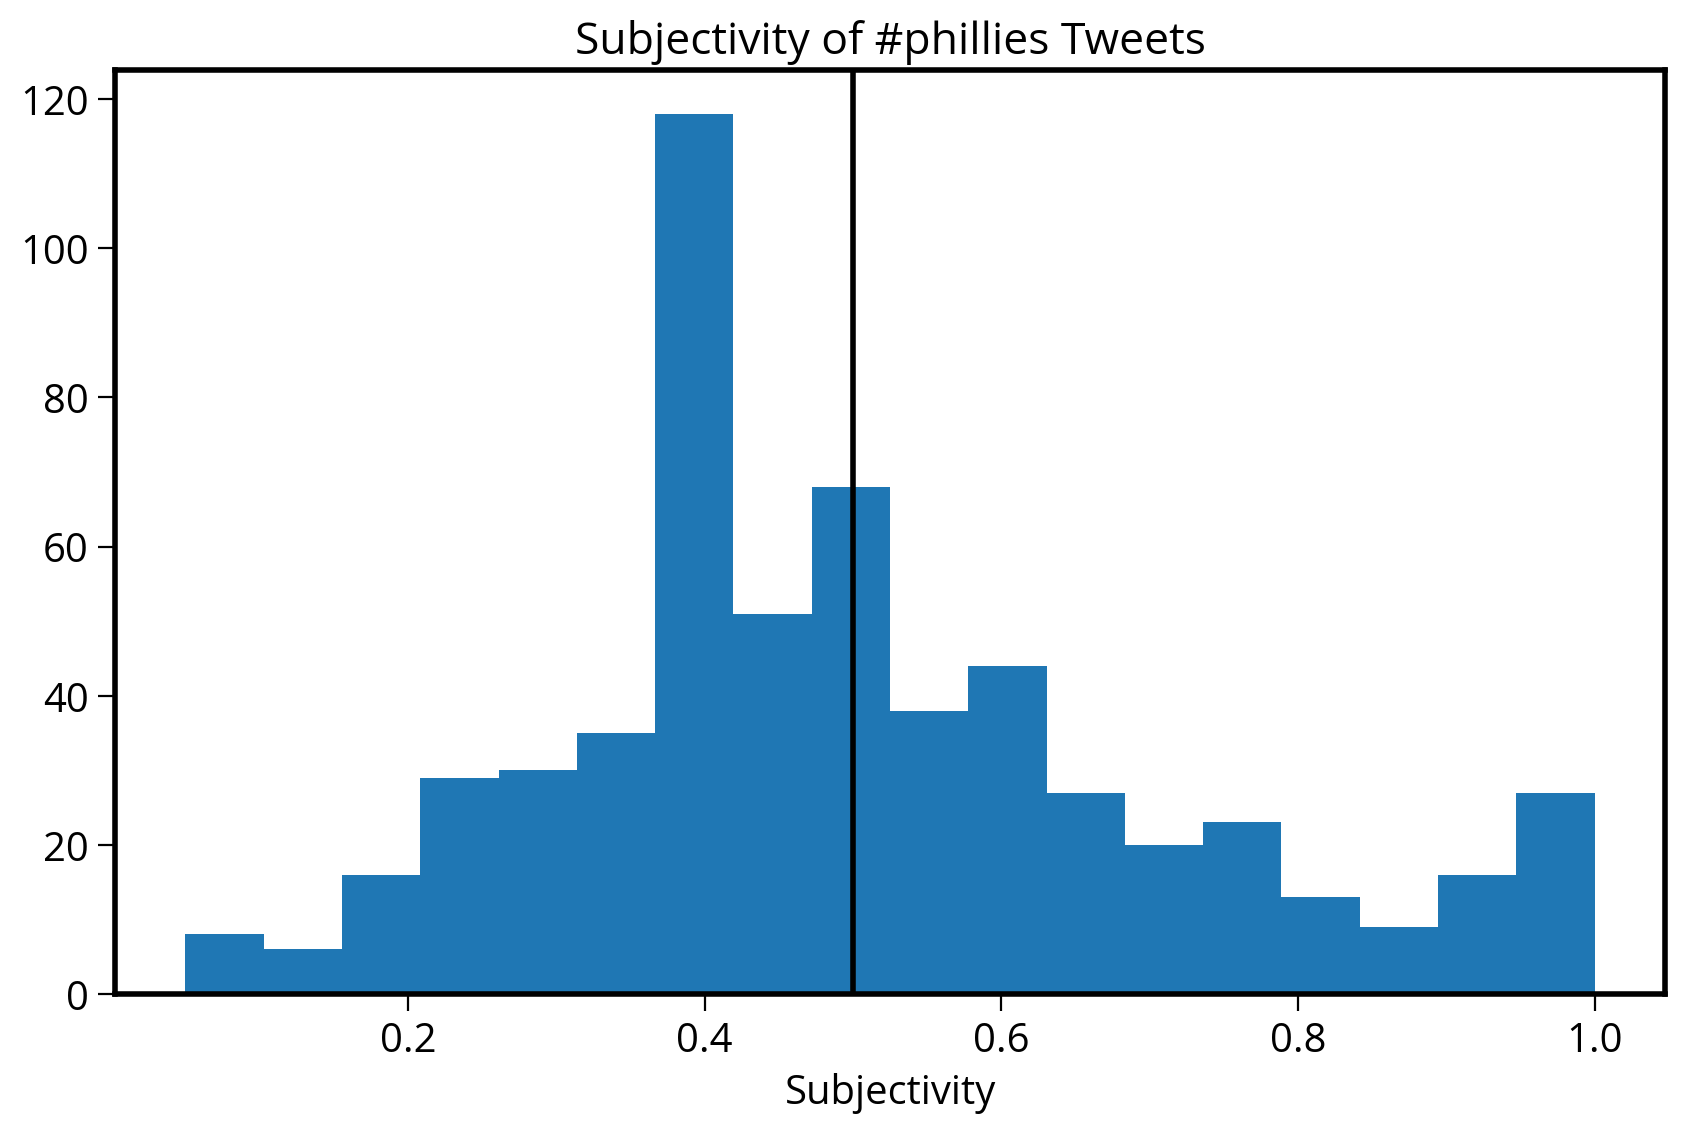

In [231]:
# create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# histogram
ax.hist(biased['subjectivity'], bins='auto')
ax.axvline(x=0.5, c='k', lw=2)

# format
ax.set_xlabel("Subjectivity")
ax.set_title("Subjectivity of #phillies Tweets", fontsize=16);

### How does polarity influence subjectivity?

Are positive/negative tweets more or less objective?

#### Seaborn's `regplot()` function

Is there a linear trend?

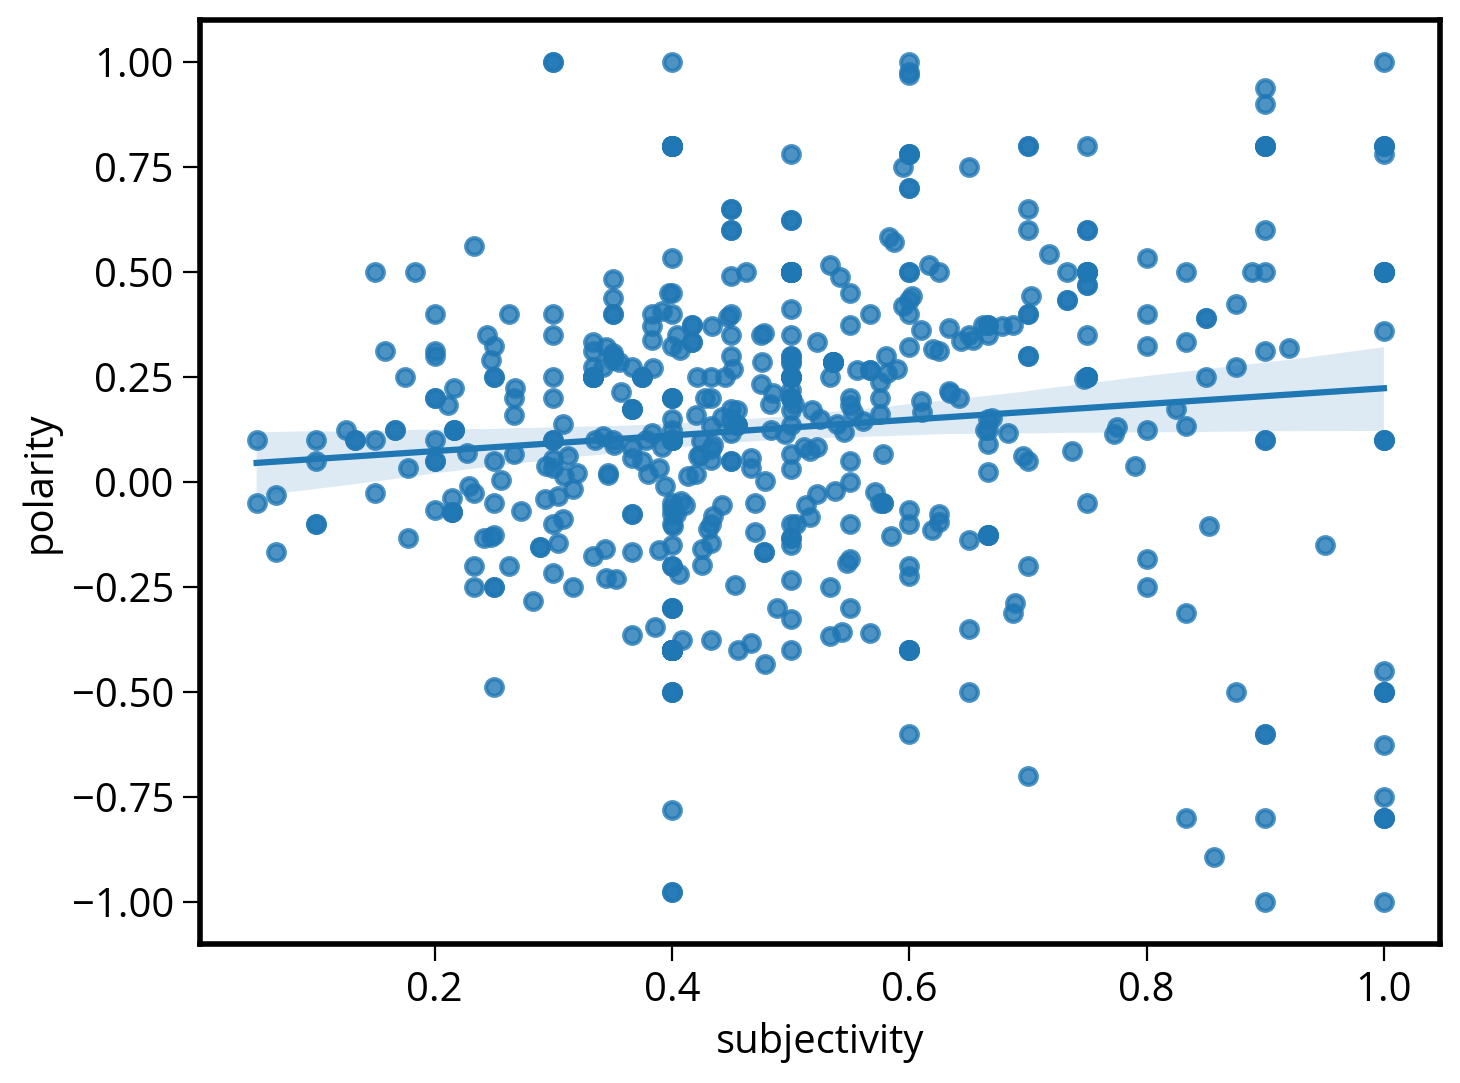

In [232]:
sns.regplot(x=biased['subjectivity'], y=biased['polarity']);

### Seaborn's `kdeplot()`

Shade the bivariate relationship

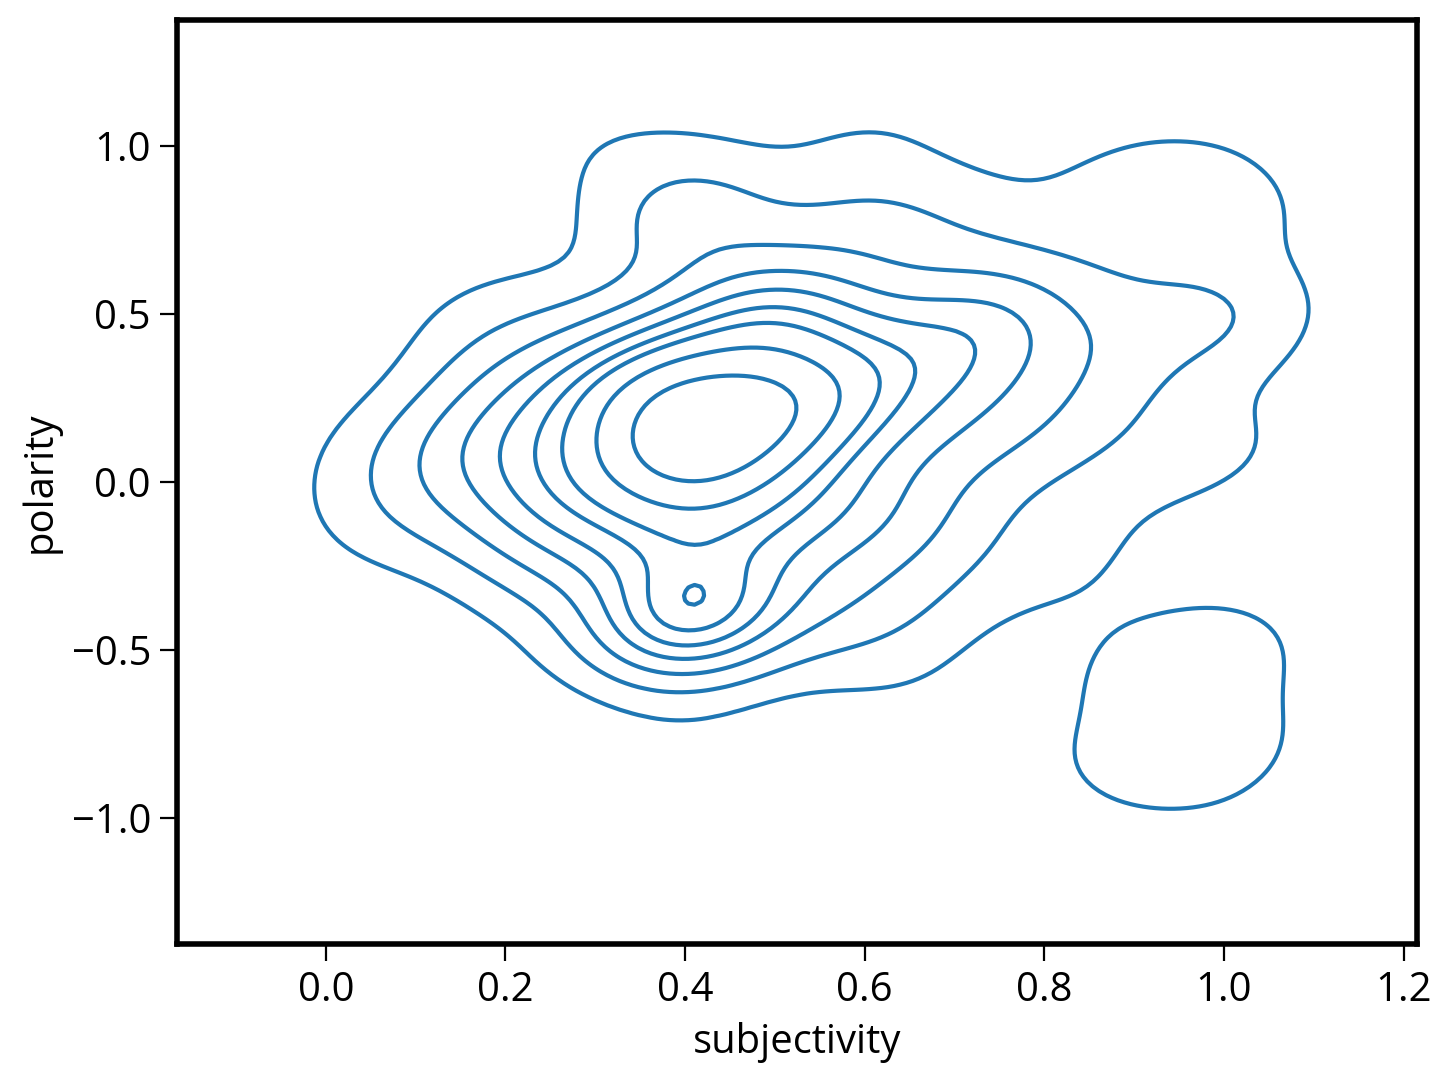

In [235]:
sns.kdeplot(x=biased['subjectivity'], y=biased['polarity']);

**Insight**: the most subjective tweets tend to be most polarized as well...

### Let's check for hourly trends too

We can plot the distribution of polarity by the tweet's hour

First, we'll add a new column that gives the day and hour of the tweet. 

We can use the built-in [strftime()](http://strftime.org/) function.

In [236]:
# this is month/day hour AM/PM
biased['date_string'] = biased['date'].dt.strftime("%-m/%d %I %p")

In [237]:
biased.head()

,date,polarity,subjectivity,text,date_string
0,2022-10-05 21:08:25+00:00,0.500000,0.500000,"Hey look, more Pooh this afternoon. #phillies ...",10/05 09 PM
2,2022-10-05 21:06:08+00:00,0.266667,0.555556,Can't say I'm suprised #Phillies have the long...,10/05 09 PM
3,2022-10-05 21:04:47+00:00,0.333333,0.333333,@Phillies retired in Top 3rd.. Valdez collects...,10/05 09 PM
4,2022-10-05 21:03:22+00:00,0.077778,0.433333,Here's a quick look at betting odds for the Wi...,10/05 09 PM
5,2022-10-05 21:02:19+00:00,0.125000,0.166667,"With his K in the 3rd, Kyle Schwarber becomes ...",10/05 09 PM


Sort the tweets in chronological order...

In [238]:
biased = biased.sort_values(by='date', ascending=True)

### Make a box and whiskers plot of the polarity

Use Seaborn's `boxplot()` function

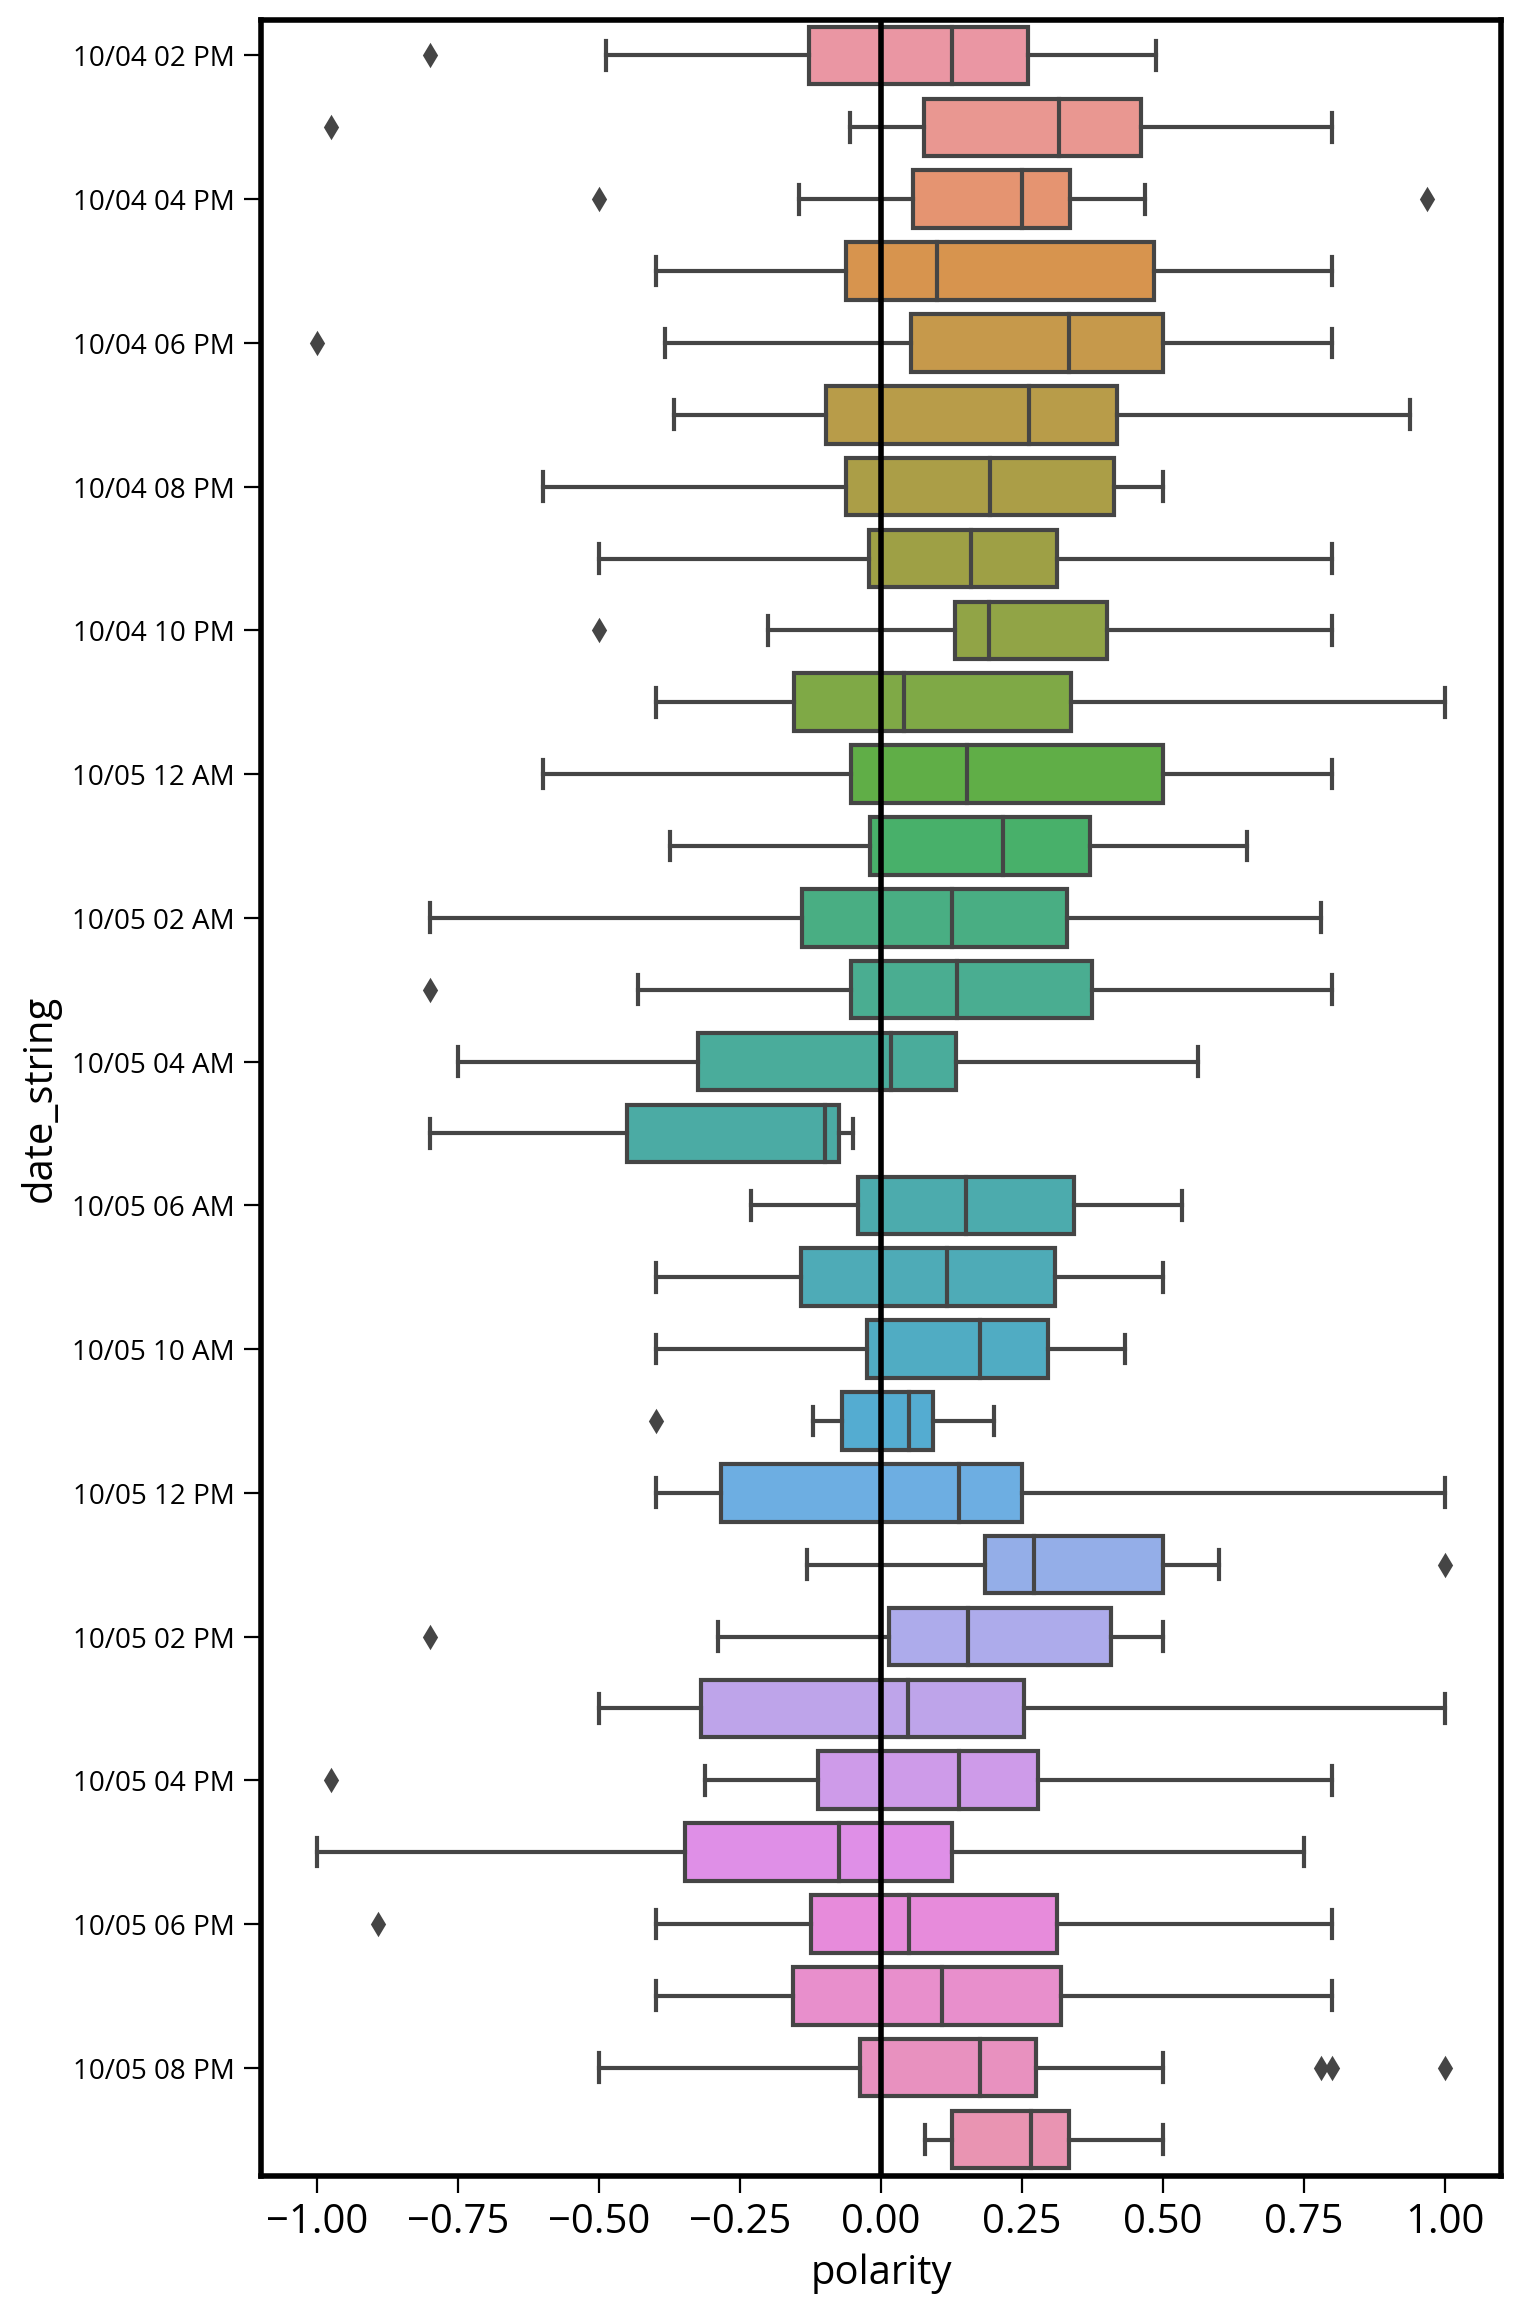

In [239]:
fig, ax = plt.subplots(figsize=(8, 14))

sns.boxplot(y='date_string', x='polarity', data=biased, ax=ax)
ax.axvline(x=0, c='k', lw=2) # neutral

# Set yticks to every other hour
yticks = ax.get_yticks()
ax.set_yticks(range(0, len(yticks), 2))
plt.setp(ax.get_yticklabels(), fontsize=10);

### And subjectivity over time...

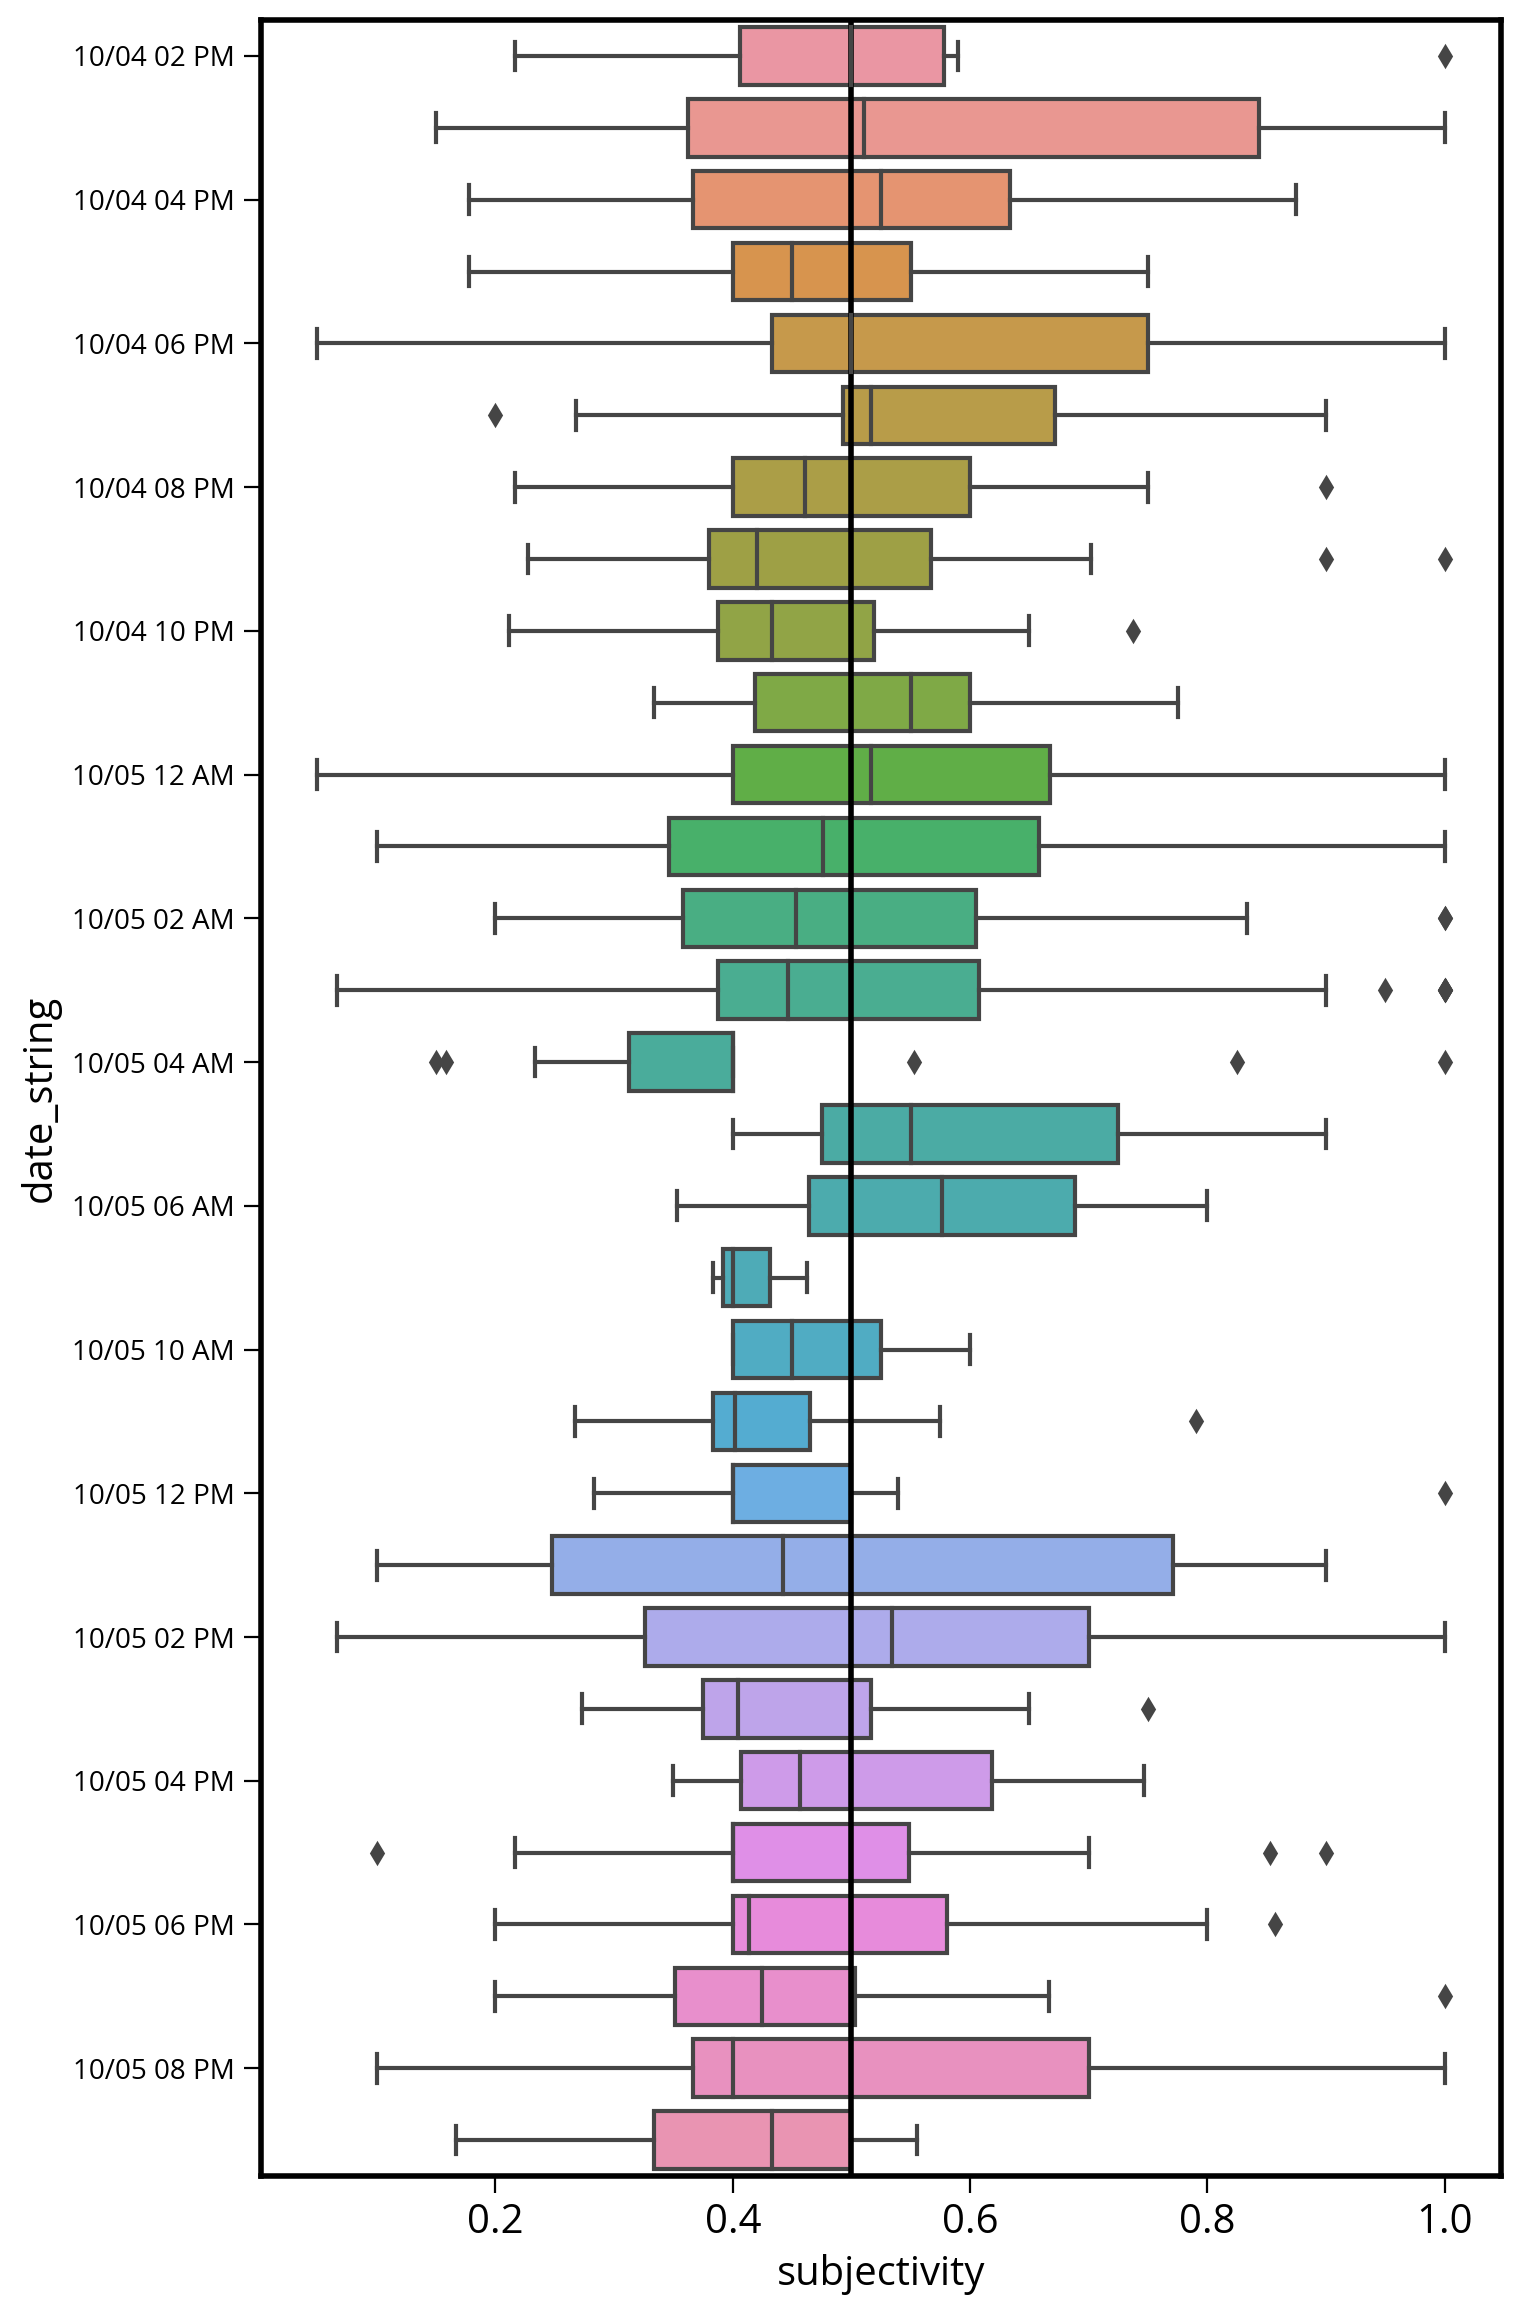

In [240]:
fig, ax = plt.subplots(figsize=(8,14))

sns.boxplot(y='date_string', x='subjectivity', data=biased)
ax.axvline(x=0.5, c='k', lw=2) # neutral

# Set yticks to every other hour
yticks = ax.get_yticks()
ax.set_yticks(range(0, len(yticks), 2))
plt.setp(ax.get_yticklabels(), fontsize=10);

## At home exercise: sentiment analysis

Analyze your set of tweets from the last exercise (or get a new set), and explore the sentiments by:

- plotting histograms of the subjectivity and polarity
- finding the most/least subjective and polarized tweets
- plotting the relationship between polarity and subjectivity
- showing hourly trends in polarity/subjectivity

Or explore trends in some new way!

## That's it!

- Next week: creating your own datasets through web scraping
- See you on Monday!